In [3]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [4]:
wv.similarity(w1='great',w2='good')

0.72915095

In [5]:
wv_great = wv['great']
wv_good = wv['good']

In [6]:
# directly see the vector using same as python indexing method or python list
print(wv_good.shape)

wv_good

(300,)


array([ 0.04052734,  0.0625    , -0.01745605,  0.07861328,  0.03271484,
       -0.01263428,  0.00964355,  0.12353516, -0.02148438,  0.15234375,
       -0.05834961, -0.10644531,  0.02124023,  0.13574219, -0.13183594,
        0.17675781,  0.27148438,  0.13769531, -0.17382812, -0.14160156,
       -0.03076172,  0.19628906, -0.03295898,  0.125     ,  0.25390625,
        0.12695312, -0.15234375,  0.03198242,  0.01135254, -0.01361084,
       -0.12890625,  0.01019287,  0.23925781, -0.08447266,  0.140625  ,
        0.13085938, -0.04516602,  0.06494141,  0.02539062,  0.05615234,
        0.24609375, -0.20507812,  0.23632812, -0.00860596, -0.02294922,
        0.05078125,  0.10644531, -0.03564453,  0.08740234, -0.05712891,
        0.08496094,  0.23535156, -0.10107422, -0.03564453, -0.04736328,
        0.04736328, -0.14550781, -0.10986328,  0.14746094, -0.23242188,
       -0.07275391,  0.19628906, -0.37890625, -0.07226562,  0.04833984,
        0.11914062,  0.06103516, -0.12109375, -0.27929688,  0.05

In [7]:
wv_great.shape, wv_good.shape


((300,), (300,))

In [8]:
import pandas as pd

In [9]:
df= pd.read_csv('fake_and_real_news.csv')

In [10]:
print(df.shape)

df.head()

(9900, 2)


,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [11]:
# checking of imbalance data
df.label.value_counts()

label
Fake    5000
Real    4900
Name: count, dtype: int64

In [12]:
df['label_num'] = df.label.map({
    'Fake':0,
    'Real':1
})

In [13]:
df.head()

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


# Now we will converting the text into a vector using gensims word2vec embeddings.

# we will do this in three steps

1.Preprocess the text to remove stop words, punctuations and get lemma for each word

2.Get word vectors for each of the words in a pre-processed sentece

3.Take a mean of all word vectors to derive the numeric representation of the entire news article
e

In [14]:
#First let's explore get_mean_vector api of gensim to see how it works
import numpy as np
r1 = np.mean([wv_good, wv_great],axis=0)

In [15]:
wv_good[:5]

array([ 0.04052734,  0.0625    , -0.01745605,  0.07861328,  0.03271484],
      dtype=float32)

In [16]:
wv_great[:5]

array([ 0.07177734,  0.20800781, -0.02844238,  0.17871094,  0.1328125 ],
      dtype=float32)

In [17]:

r1[:5]

array([ 0.05615234,  0.1352539 , -0.02294922,  0.12866211,  0.08276367],
      dtype=float32)

In [18]:
r2 = wv.get_mean_vector(["good", "great"],pre_normalize=False)

In [19]:
r2[:5]

array([ 0.05615234,  0.1352539 , -0.02294922,  0.12866211,  0.08276367],
      dtype=float32)

# now making function for preprocessing and vectorization both

In [20]:
import spacy
nlp = spacy.load("en_core_web_lg") # if this fails then run "python -m spacy download en_core_web_lg" to download that model

def preprocess_and_vectorize(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
        
    return wv.get_mean_vector(filtered_tokens)

In [25]:
v = preprocess_and_vectorize("Don't worry if you don't understand")
print(v.shape)
v[:3]

(300,)


array([ 0.00235079, -0.00284596, -0.03638233], dtype=float32)

In [26]:
df['vector'] = df['Text'].apply(lambda text: preprocess_and_vectorize(text))


In [28]:
df.head()

,Text,label,label_num,vector
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0,"[0.008657642, 0.019024342, -0.011917442, 0.032..."
1,U.S. conservative leader optimistic of common ...,Real,1,"[0.010864096, 0.007960429, 0.0011915653, 0.014..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1,"[0.018134918, 0.0062743523, -0.005872244, 0.03..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0,"[0.01255197, 0.012613623, 5.9780963e-05, 0.021..."
4,Democrats say Trump agrees to work on immigrat...,Real,1,"[-0.0019059887, 0.011889367, 0.0035395357, 0.0..."


# Train_test_split

In [29]:
from sklearn.model_selection import train_test_split

In [41]:
X = df.vector.values
y = df.label_num

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2002)

In [42]:
X_train.shape, X_test.shape

((6930,), (2970,))

In [43]:
y_train.shape, y_test.shape

((6930,), (2970,))

In [45]:
X_train[:2]

array([array([-0.0149143 , -0.00712963,  0.01208838,  0.01889682, -0.01735053,
              -0.01131663,  0.03013263, -0.01917489,  0.0408859 ,  0.00134291,
              -0.00632652, -0.02476355,  0.003762  ,  0.00992899, -0.05425043,
               0.03010971,  0.00382455,  0.01880872, -0.00993711, -0.01549593,
               0.00513638,  0.01083039, -0.00523386,  0.01188493,  0.00239202,
              -0.00655699, -0.02258827,  0.00992955,  0.00148324,  0.00019238,
              -0.00942275, -0.02785728, -0.02360783, -0.01291712,  0.00863132,
              -0.01445683,  0.01164589,  0.0160188 ,  0.00256477,  0.00679529,
               0.00831909, -0.00159888,  0.00759152,  0.02097559, -0.0314117 ,
              -0.03852975, -0.01278365,  0.00196658, -0.03446203,  0.02562197,
               0.00209743,  0.00527203, -0.01020132, -0.0154087 ,  0.0019528 ,
               0.01361215, -0.02260491, -0.03189059, -0.01120664, -0.02016774,
              -0.02000923,  0.01695434, -0.01566144,

In [46]:
# X_train having array inside array 
# converting it into one array with 2d
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [47]:
X_train_2d[:2]

array([[-1.49142994e-02, -7.12963473e-03,  1.20883835e-02,
         1.88968163e-02, -1.73505284e-02, -1.13166347e-02,
         3.01326327e-02, -1.91748925e-02,  4.08858955e-02,
         1.34290964e-03, -6.32652361e-03, -2.47635506e-02,
         3.76199954e-03,  9.92898550e-03, -5.42504303e-02,
         3.01097129e-02,  3.82454926e-03,  1.88087244e-02,
        -9.93710663e-03, -1.54959280e-02,  5.13637951e-03,
         1.08303903e-02, -5.23385732e-03,  1.18849333e-02,
         2.39202450e-03, -6.55698730e-03, -2.25882716e-02,
         9.92955267e-03,  1.48323842e-03,  1.92384585e-04,
        -9.42275207e-03, -2.78572794e-02, -2.36078277e-02,
        -1.29171237e-02,  8.63132346e-03, -1.44568319e-02,
         1.16458880e-02,  1.60188004e-02,  2.56477483e-03,
         6.79528760e-03,  8.31909105e-03, -1.59888365e-03,
         7.59151578e-03,  2.09755879e-02, -3.14116962e-02,
        -3.85297462e-02, -1.27836550e-02,  1.96658378e-03,
        -3.44620273e-02,  2.56219693e-02,  2.09743436e-0

# train machine learning model
we used multiple machine learning algo but gradient boosting gave the best result

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

#1. creating a GradientBoosting model object
clf = GradientBoostingClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1479
           1       0.98      0.99      0.98      1491

    accuracy                           0.98      2970
   macro avg       0.98      0.98      0.98      2970
weighted avg       0.98      0.98      0.98      2970



# Another prediction,

In [49]:
test_news = [
    "Michigan governor denies misleading U.S. House on Flint water (Reuters) - Michigan Governor Rick Snyder denied Thursday that he had misled a U.S. House of Representatives committee last year over testimony on Flintâ€™s water crisis after lawmakers asked if his testimony had been contradicted by a witness in a court hearing. The House Oversight and Government Reform Committee wrote Snyder earlier Thursday asking him about published reports that one of his aides, Harvey Hollins, testified in a court hearing last week in Michigan that he had notified Snyder of an outbreak of Legionnairesâ€™ disease linked to the Flint water crisis in December 2015, rather than 2016 as Snyder had testified. â€œMy testimony was truthful and I stand by it,â€ Snyder told the committee in a letter, adding that his office has provided tens of thousands of pages of records to the committee and would continue to cooperate fully.  Last week, prosecutors in Michigan said Dr. Eden Wells, the stateâ€™s chief medical executive who already faced lesser charges, would become the sixth current or former official to face involuntary manslaughter charges in connection with the crisis. The charges stem from more than 80 cases of Legionnairesâ€™ disease and at least 12 deaths that were believed to be linked to the water in Flint after the city switched its source from Lake Huron to the Flint River in April 2014. Wells was among six current and former Michigan and Flint officials charged in June. The other five, including Michigan Health and Human Services Director Nick Lyon, were charged at the time with involuntary manslaughter",
    " WATCH: Fox News Host Loses Her Sh*t, Says Investigating Russia For Hacking Our Election Is Unpatriotic This woman is insane.In an incredibly disrespectful rant against President Obama and anyone else who supports investigating Russian interference in our election, Fox News host Jeanine Pirro said that anybody who is against Donald Trump is anti-American. Look, it s time to take sides,  she began.",
    " Sarah Palin Celebrates After White Man Who Pulled Gun On Black Protesters Goes Unpunished (VIDEO) Sarah Palin, one of the nigh-innumerable  deplorables  in Donald Trump s  basket,  almost outdid herself in terms of horribleness on Friday."
]

test_news_vectors = [preprocess_and_vectorize(n) for n in test_news]
clf.predict(test_news_vectors)

array([1, 0, 0], dtype=int64)

# Confusion matrix

In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[1442,   37],
       [  22, 1469]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

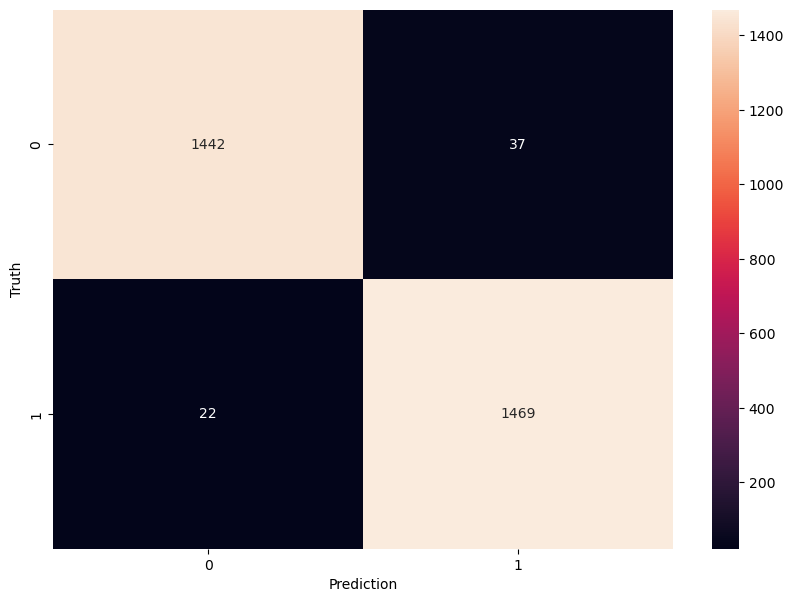

In [51]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')